# Climate Set

In [185]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from ds_charts import get_variable_types

datasets = ['datasets/drought.csv', 'datasets/diabetic_data.csv']
dict_path = {'Set1':datasets[1], 'Set2':datasets[0]}
dict_name = {'Set1':'diabetic', 'Set2':'climate'}
dict_target = {'Set1':'readmitted', 'Set2':'class'}

set_ID = 2

file_path = dict_path['Set'+str(set_ID)]
file_name = dict_name['Set'+str(set_ID)]
target = dict_target['Set'+str(set_ID)]
data = pd.read_csv(file_path, na_values='?', low_memory=False)
print(data.shape)

print(data[target].unique())

variables = get_variable_types(data)
numeric_vars = variables['Numeric']
symbolic_vars = variables['Symbolic']
binary_vars = variables['Binary']
date_vars = variables['Date']

(59429, 52)
[1 0]


In [165]:
for var in binary_vars+symbolic_vars:
    if var!='date':
        print(var, (data[var].unique()))

SQ5 [1 0]
SQ6 [1 0]
class [1 0]


In [166]:
print()
print(data.dtypes)


fips               int64
date              object
PRECTOT          float64
PS               float64
QV2M             float64
T2M              float64
T2MDEW           float64
T2MWET           float64
T2M_MAX          float64
T2M_MIN          float64
T2M_RANGE        float64
TS               float64
WS10M            float64
WS10M_MAX        float64
WS10M_MIN        float64
WS10M_RANGE      float64
WS50M            float64
WS50M_MAX        float64
WS50M_MIN        float64
WS50M_RANGE      float64
lat              float64
lon              float64
elevation          int64
slope1           float64
slope2           float64
slope3           float64
slope4           float64
slope5           float64
slope6           float64
slope7           float64
slope8           float64
aspectN          float64
aspectE          float64
aspectS          float64
aspectW          float64
aspectUnknown    float64
WAT_LAND         float64
NVG_LAND           int64
URB_LAND         float64
GRS_LAND         float64

In [167]:
#ordenar dos registos mais antigos para os mais recentes

data['date'] = pd.to_datetime(data['date']);
data.sort_values(by=['date'], inplace=True)
data.to_csv(f'datasets/drought_data_sorted.csv', index=False)


data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data.shape
data.drop(columns='date', inplace=True)

In [168]:
print(data['year'].unique())

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016]


total: 54


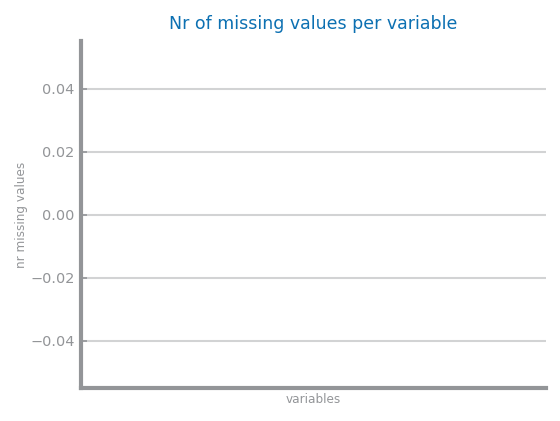

In [169]:
#missing values imputation

from matplotlib.pyplot import figure, savefig
from ds_charts import bar_chart

mv = {}
figure()
c = 0
for var in data:
    c += 1
    nr = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr
        c += nr
    #print(var, nr)

print('total:', c)
bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable', xlabel='variables', ylabel='nr missing values', rotation=True)

In [176]:
#outliers imputation

from pandas import DataFrame
from ds_charts import get_variable_types

OUTLIER_PARAM: int = 1.5 # define the number of stdev to use or the IQR scale (usually 1.5)
OPTION = 'iqr'  # or 'stdev'

def determine_outlier_thresholds(summary5: DataFrame, var: str):
    if 'iqr' == OPTION:
        iqr = OUTLIER_PARAM * (summary5[var]['75%'] - summary5[var]['25%'])
        top_threshold = summary5[var]['75%']  + iqr
        bottom_threshold = summary5[var]['25%']  - iqr
    else:  # OPTION == 'stdev'
        std = OUTLIER_PARAM * summary5[var]['std']
        top_threshold = summary5[var]['mean'] + std
        bottom_threshold = summary5[var]['mean'] - std
    return top_threshold, bottom_threshold

numeric_vars = get_variable_types(data)['Numeric']
if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')
print('Original data:', data.shape)
summary5 = data.describe(include='number')

for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var)
    outliers = data[(data[var] > top_threshold) | (data[var] < bottom_threshold)]
    data.drop(outliers.index, axis=0, inplace=True)
print('data after dropping outliers:', data.shape)

Original data: (59429, 52)
data after dropping outliers: (15948, 52)


In [186]:
print(data['date'])

0        04/01/2000
1        11/01/2000
2        18/01/2000
3        25/01/2000
4        01/02/2000
            ...    
59424    29/11/2016
59425    06/12/2016
59426    13/12/2016
59427    20/12/2016
59428    27/12/2016
Name: date, Length: 59429, dtype: object


In [187]:
y = data.pop(target).values
X = data.values
labels = unique(y)
labels.sort()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=0)

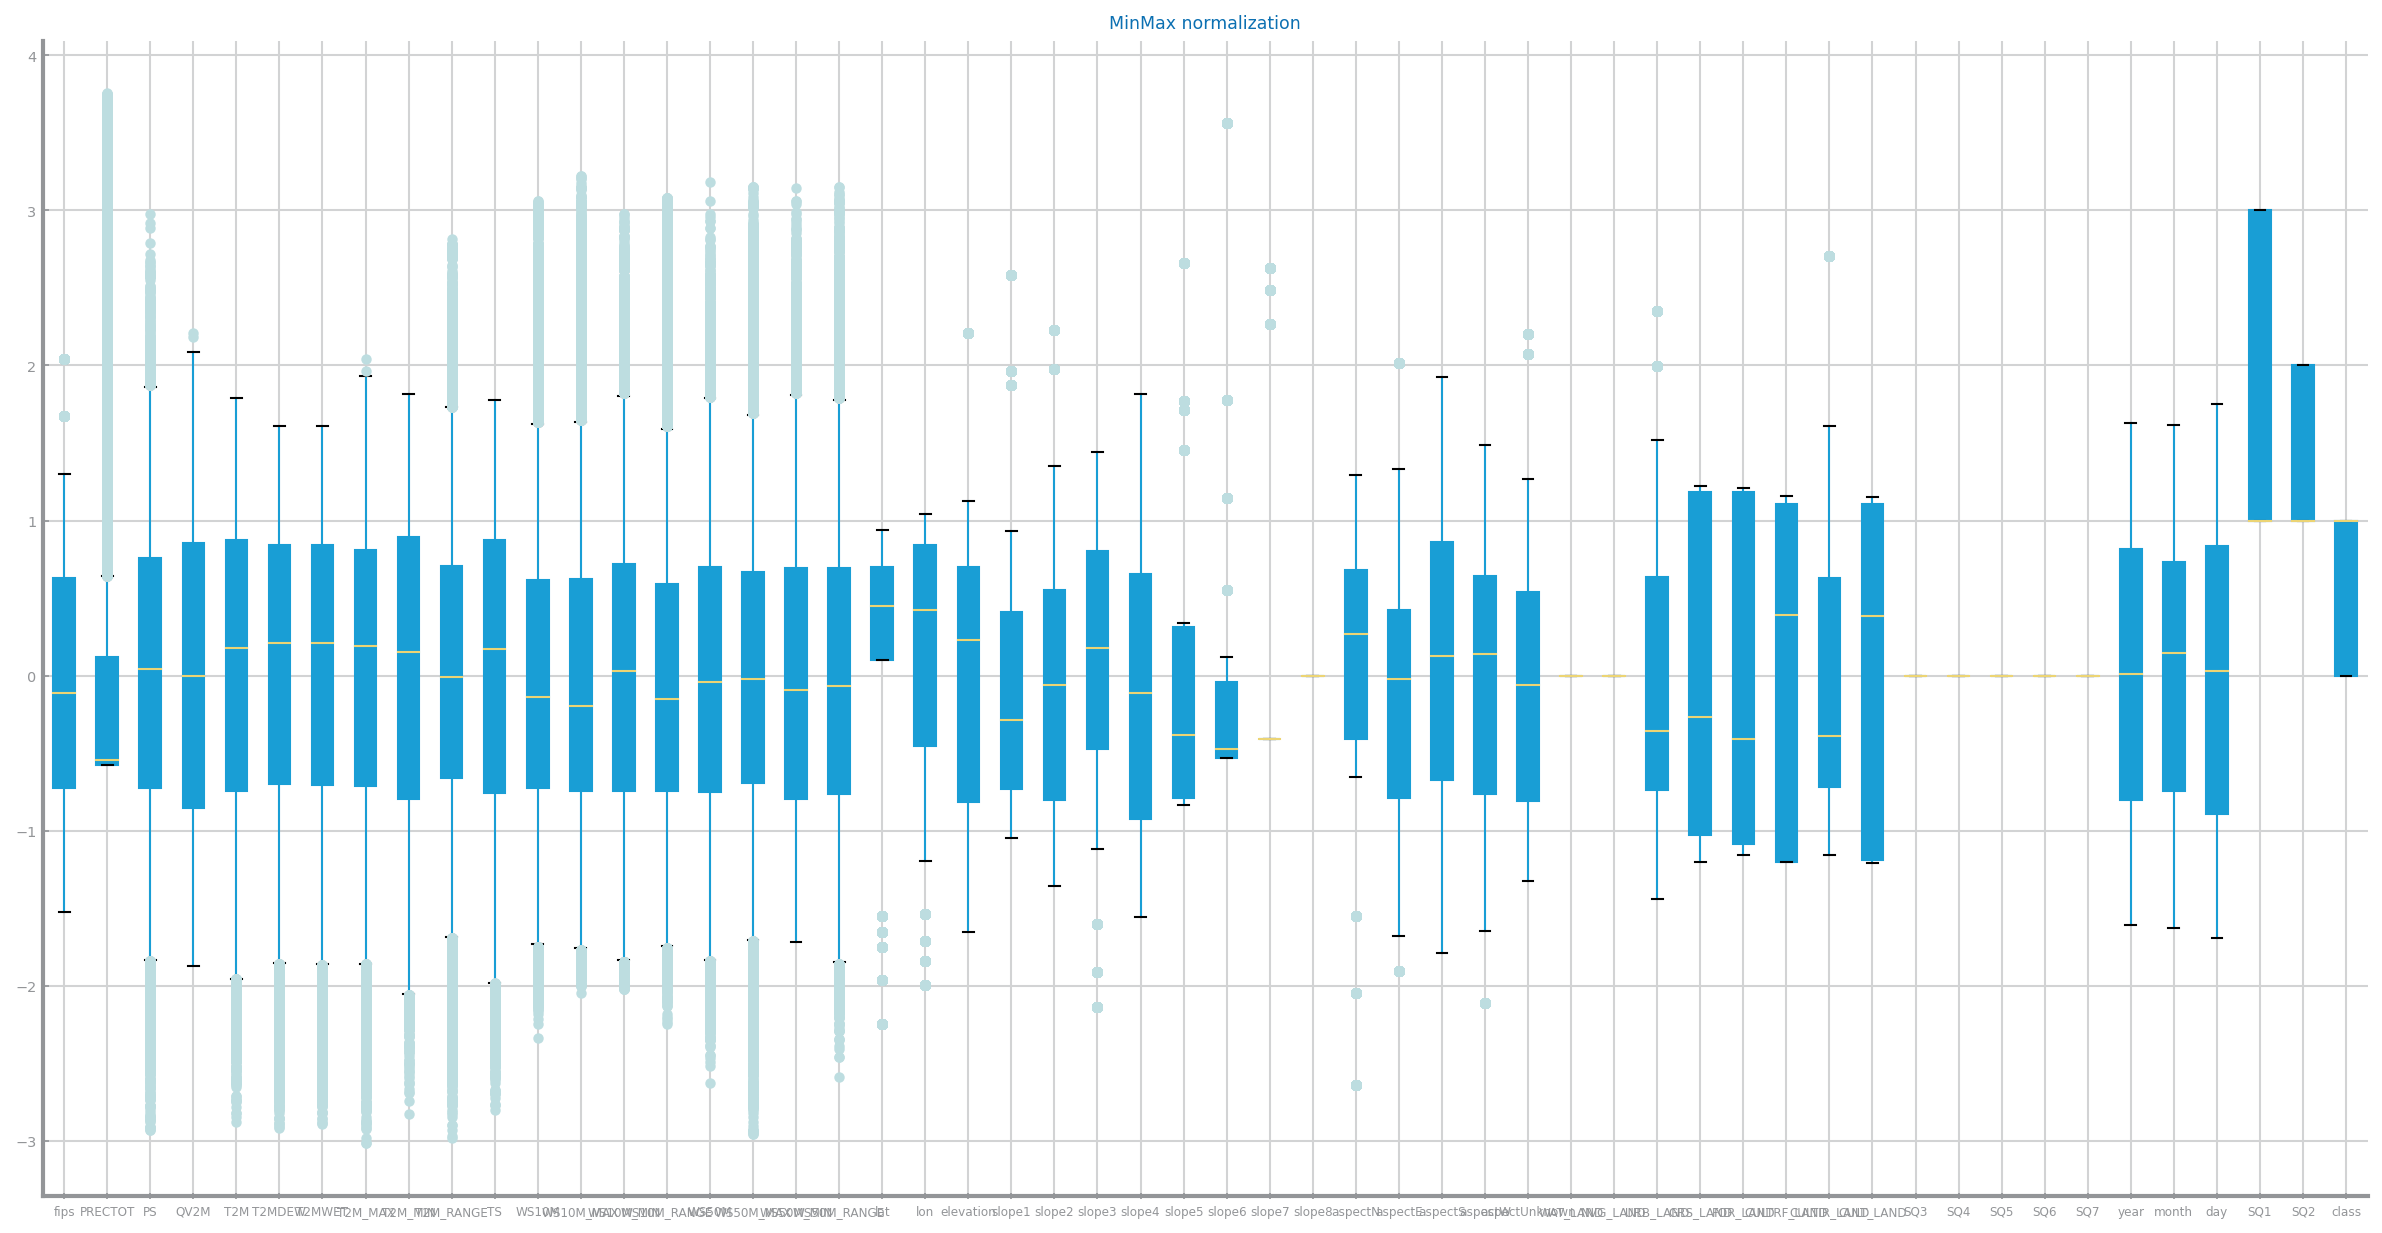

In [152]:
#scaling - the best one from the previous lab was zscore
from matplotlib.pyplot import subplots, show

from ds_charts import get_variable_types

variable_types = get_variable_types(data)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[boolean_vars]

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_zscore = concat([tmp, df_sb,  df_bool], axis=1)

fig, axs = subplots(1, 1, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('MinMax normalization')
norm_data_zscore.boxplot(ax=axs[0, 0])
show()

Minority class = 0 : 7783
Majority class = 1 : 8165
Proportion: 0.95 : 1


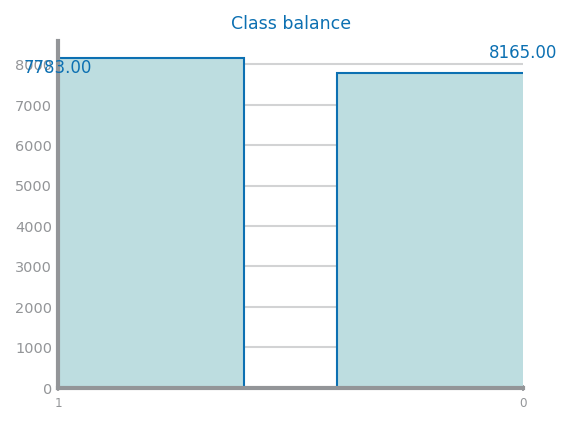

In [40]:
from pandas import read_csv
from matplotlib.pyplot import figure, savefig, show
from ds_charts import bar_chart
import matplotlib.pyplot as plt
import numpy

original = norm_data_zscore.copy()
class_var = 'class'

target_count = original[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class =', positive_class, ':', target_count[positive_class])
print('Majority class =', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}

figure()
bar_chart(target_count.index, target_count.values, title='Class balance')

#ax.set_xticks(numpy.arange(len(index)), labels=index)
#ax.bar_label(hbars, fmt='%.2f')

#savefig(f'images/{file}_balance.png')
show()

#the dataset is nearly balanced, so the final prepared dataset is the one obtained after apllying the zscore scaling
norm_data_zscore.to_csv(f'datasets/drought_prepared.csv', index=False)



In [156]:
def split(name):
    import numpy as np
    from pandas import read_csv, concat, unique, DataFrame
    import matplotlib.pyplot as plt
    import ds_charts as ds
    from ds_charts import multiple_bar_chart
    from sklearn.model_selection import train_test_split

    #approach = number
    #dict = {1: data_mv_drop_variables, 2: data_mv_other}
    dataset = name.copy()

    target = 'class'
    values = {}

    y = dataset.pop(target).values
    X = dataset.values
    labels = unique(y)
    labels.sort()

    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=0)


    train = concat([DataFrame(trnX, columns=dataset.columns), DataFrame(trnY,columns=[target])], axis=1)
    #train.to_csv(f'datasets/{file_name}_approach1_train.csv', index=False)

    test = concat([DataFrame(tstX, columns=dataset.columns), DataFrame(tstY,columns=[target])], axis=1)
    #test.to_csv(f'datasets/{file_name}_approach1_test.csv', index=False)
    values['Train'] = [len(np.delete(trnY, np.argwhere(trnY!=0))), len(np.delete(trnY, np.argwhere(trnY!=1)))]
    values['Test'] = [len(np.delete(tstY, np.argwhere(tstY!=0))), len(np.delete(tstY, np.argwhere(tstY!=1)))]

    plt.figure(figsize=(12,4))
    multiple_bar_chart(['0','1'], values, title='Data distribution per dataset')
    plt.show()

    return [trnX, tstX, trnY, tstY]


def naive_bayes(trn_tst):
    
    from ds_charts import plot_evaluation_results, bar_chart, plot_confusion_matrix
    from sklearn.metrics import confusion_matrix
    from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
    from sklearn.metrics import accuracy_score
    from pandas import read_csv, concat, unique, DataFrame

    trnX = trn_tst[0]
    tstX = trn_tst[1]
    trnY = trn_tst[2]
    tstY = trn_tst[3]

    labels = unique(trnY)
    labels.sort()

    estimators = {'GaussianNB': GaussianNB(),
                #'MultinomialNB': MultinomialNB(),
                'BernoulliNB': BernoulliNB(),
                #'CategoricalNB': CategoricalNB
                }

    xvalues = []
    yvalues = []
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY = estimators[clf].predict(tstX)
        yvalues.append(accuracy_score(tstY, prdY))

    figure()
    bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
    #savefig(f'images/{file_tag}_nb_study.png')

    clf = GaussianNB()
    clf.fit(trnX, trnY)
    prd_trn = clf.predict(trnX)
    prd_tst = clf.predict(tstX)

    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
    plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,0], )
    plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,1], normalize=True)
    plt.tight_layout()
    plt.show()

    plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

    plt.show()


def KNN(trn_tst):
    from numpy import ndarray
    from pandas import DataFrame, read_csv, unique
    from matplotlib.pyplot import figure, savefig, show
    from sklearn.neighbors import KNeighborsClassifier
    from ds_charts import plot_evaluation_results, multiple_line_chart, plot_overfitting_study
    from sklearn.metrics import accuracy_score
    from ds_charts import plot_evaluation_results, bar_chart, plot_confusion_matrix
    from sklearn.metrics import confusion_matrix
    from pandas import read_csv, concat, unique, DataFrame

    trnX = trn_tst[0]
    tstX = trn_tst[1]
    trnY = trn_tst[2]
    tstY = trn_tst[3]

    labels = unique(trnY)
    labels.sort()

    eval_metric = accuracy_score
    nvalues = [1,5,11,15,19,21]
    dist = ['manhattan', 'euclidean', 'chebyshev']
    KNNscores = {}
    best = (0, '')
    last_best = 0
    for d in dist:
        y_tst_values = []
        for n in nvalues:
            print(d,n)
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(trnX, trnY)
            prd_tst_Y = knn.predict(tstX)
            y_tst_values.append(eval_metric(tstY, prd_tst_Y))
            if y_tst_values[-1] > last_best:
                best = (n, d)
                last_best = y_tst_values[-1]
        KNNscores[d] = y_tst_values
    
    from ds_charts import multiple_line_chart
    figure()
    multiple_line_chart(nvalues, KNNscores, title='KNN variants', xlabel='n', ylabel=str(accuracy_score), percentage=True)
    #savefig('images/{file_tag}_knn_study.png')
    show()
    print('Best results with %d neighbors and %s'%(best[0], best[1]))

    clf = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
    clf.fit(trnX, trnY)
    prd_tst = clf.predict(tstX)

    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
    plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,0], )
    plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,1], normalize=True)
    plt.tight_layout()

    clf = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
    clf.fit(trnX, trnY)
    prd_tst = clf.predict(tstX)
    prd_trn = clf.predict(trnX)
    plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

    plt.show()


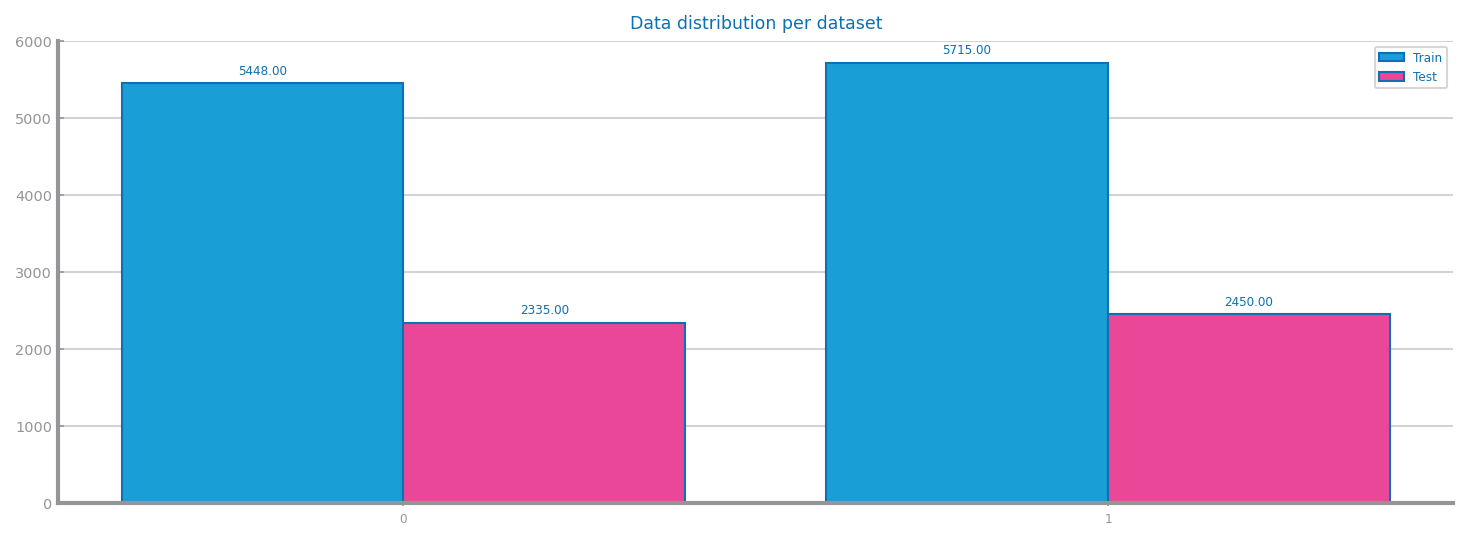

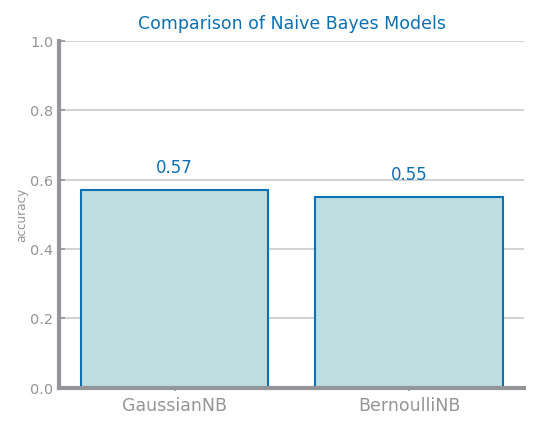

<Figure size 600x450 with 0 Axes>

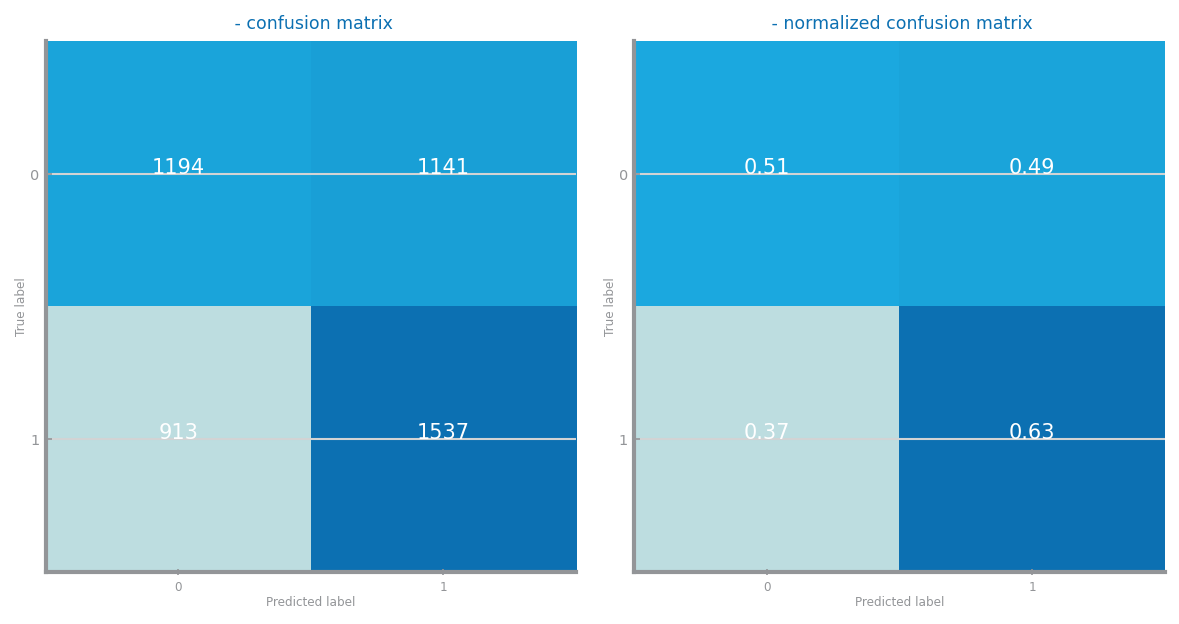

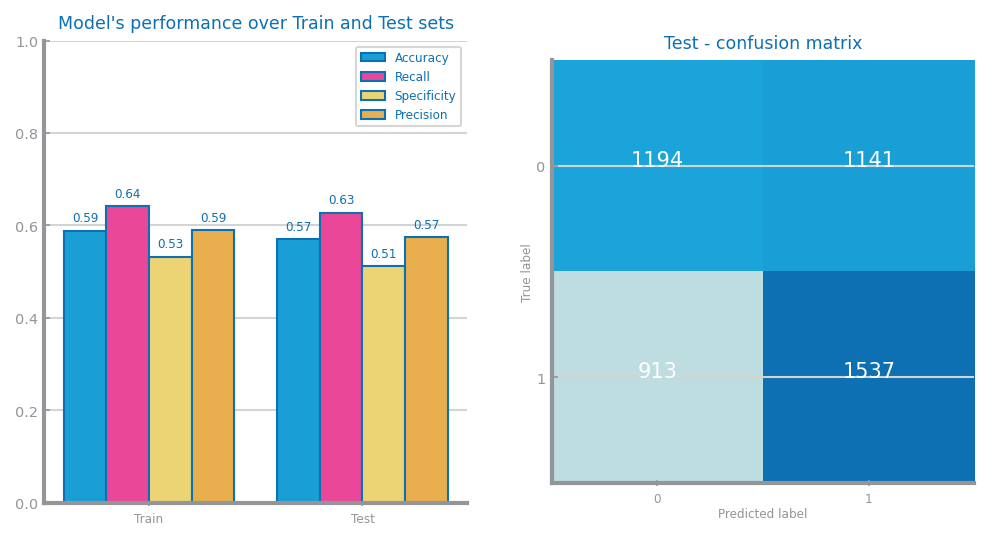

In [158]:
dataset = read_csv('datasets/drought_prepared.csv')
naive_bayes(split(dataset))

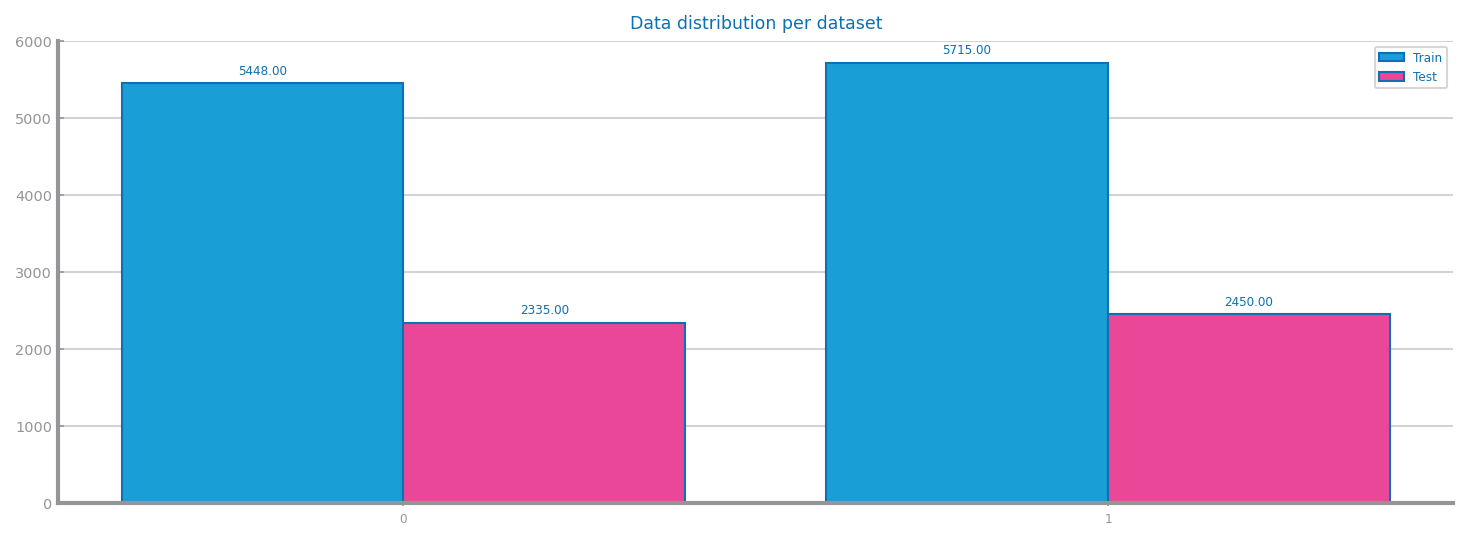

manhattan 1
manhattan 5
manhattan 11
manhattan 15
manhattan 19
manhattan 21
euclidean 1
euclidean 5
euclidean 11
euclidean 15
euclidean 19
euclidean 21
chebyshev 1
chebyshev 5
chebyshev 11
chebyshev 15
chebyshev 19
chebyshev 21


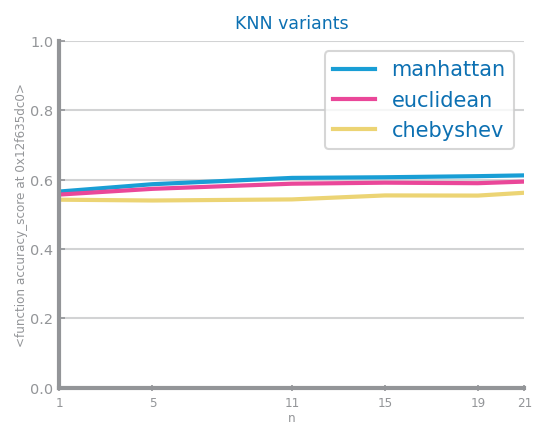

Best results with 21 neighbors and manhattan


<Figure size 600x450 with 0 Axes>

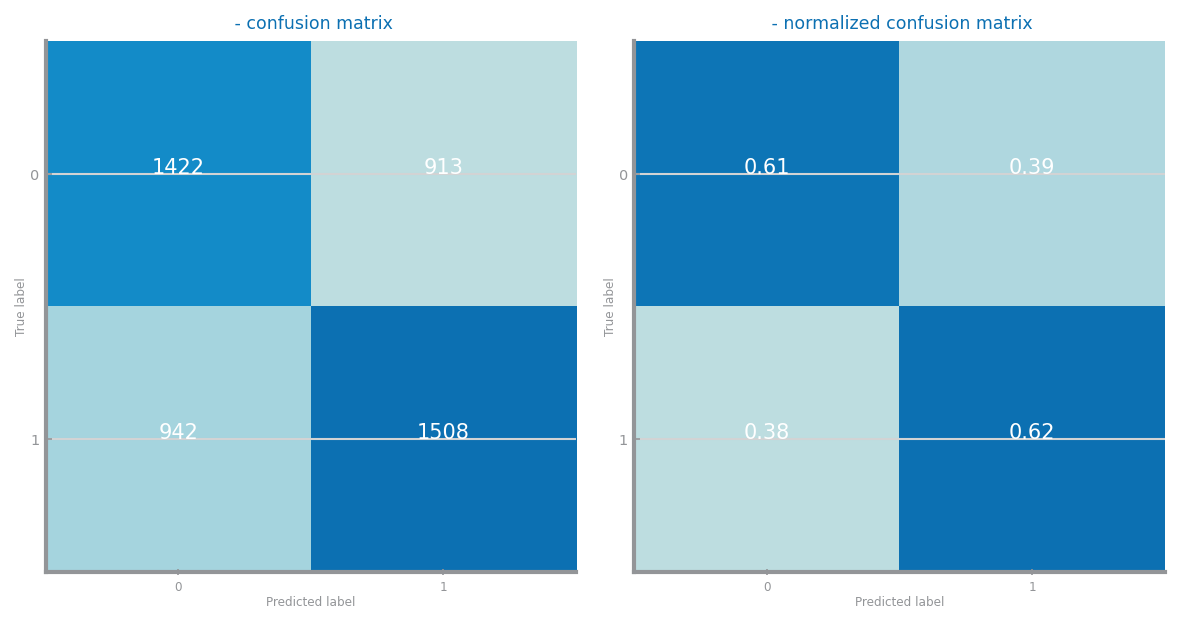

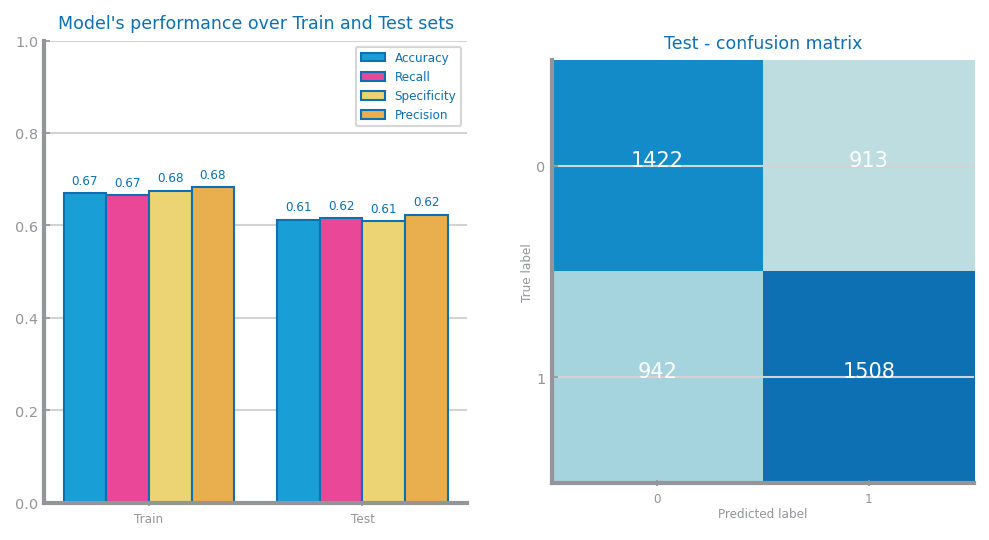

In [159]:
dataset = read_csv('datasets/drought_prepared.csv')
KNN(split(dataset))